# Import Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot

from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score,make_scorer
from sklearn.pipeline import Pipeline

from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

# pip install arch
from arch import arch_model

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
df = pd.read_csv("../datasets/features_data.csv")

In [3]:
df['local_time'] = pd.to_datetime(df['local_time'])
df.set_index('local_time', drop = True, inplace = True)

In [4]:
df.shape

(10060, 79)

# Functions

In [5]:
# Function to test ADF Test
def adf_test(df, columns):
    for col in columns: # Loop for each Company
        result = adfuller(df[col].values, autolag='AIC') # ADF Test
        print(f'ADF Statistic for {col}: {result[0]}')
        print(f'p-value for {col}: {result[1]}')
        for key, value in result[4].items():
            print('Critial Values:')
            print(f'   {key}, {value}')
        if result[1] > 0.05:
            print(f'P-Value is more than 0.05, Null Hypothesis cannot be Rejected. Hence, {col} is not Stationary.')
        else:
            print(f'P-Value is less than 0.05, Null Hypothesis is Rejected. {col} is Stationary.')
        print('-'*40) # print ------ to seperate each loop

# Split Dataset into respective stocks

Because we are predicting the prices of the respective stocks. A general model will not be accurate enough. Hence, we will be creating 1 model for each stock.

In [6]:
# Split Dataset
aapl = df[df['stock'] == "AAPL"]
crm = df[df['stock'] == "CRM"]
dis = df[df['stock'] == "DIS"]
fb = df[df['stock'] == "FB"]
gm = df[df['stock'] == "GM"]
intc = df[df['stock'] == "INTC"]
nke = df[df['stock'] == "NKE"]
trip = df[df['stock'] == "TRIP"]
twtr = df[df['stock'] == "TWTR"]
v = df[df['stock'] == "V"]

# ARIMA

ARIMA — AutoRegressor(p) Integrated(d) Moving Average(q).

ARIMA is a regression model whose features are determined by the below parameters

    p — Number of previous values to consider for estimating the current value
    d — n_diff in the previous code snippet
    q — If we consider a moving average to estimate each value, then q indicates the number of previous errors

From the EDA Section before, we know that the data is not stationary. To make it stationary, we have to take the difference from the current and the period before.

In [7]:
# For ARIMA we will be using the close_price column only as it is the variable we want to forecast
aapl_arima = aapl[['close_price']]
aapl_arima.head()

,close_price
local_time,
2015-12-04 22:30:00,119.029999
2015-12-07 22:30:00,118.279999
2015-12-08 22:30:00,118.230003
2015-12-09 22:30:00,115.620003
2015-12-10 22:30:00,116.169998


In [8]:
aapl_diff = aapl_arima.diff().dropna()
aapl_diff.head()

,close_price
local_time,
2015-12-07 22:30:00,-0.750000
2015-12-08 22:30:00,-0.049995
2015-12-09 22:30:00,-2.610001
2015-12-10 22:30:00,0.549995
2015-12-11 22:30:00,-2.989998


In [9]:
# ADF Test for Stationarity
result = adfuller(aapl_diff['close_price'].values, autolag='AIC') # ADF Test
print(f'ADF Statistic for: {result[0]}')
print(f'p-value for: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic for: -9.407241001114738
p-value for: 5.965800167403927e-16
Critial Values:
   1%, -3.4369325637409154
Critial Values:
   5%, -2.8644462162311934
Critial Values:
   10%, -2.568317409920808


In [10]:
# KPSS Test for Stationarity
result = kpss(aapl_diff['close_price'].values, regression='c') # KPSS Test
print(f'KPSS Statistic for: {result[0]}')
print(f'p-value for: {result[1]}')
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

KPSS Statistic for: 0.1400810692497183
p-value for: 0.1
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


Since the p-value of ADF test is less than 0.05 and the p-value of KPSS test is more than 0.05, that means the difference is stationary by differencing once.

## Determine the value for (p),(d),(q)

We determine the value (p) and (q) using the PACF(Partial Auto Correlation Function) and ACF(Auto Correlation Function) graphs respectively.

Determining a Value of $p$ based on the ACF and PACF.

If the PACF (partial autocorrelation function) has a sharp cut-off and the lag-1 ACF (autocorrelation function) value is positive, choose $p$ to be the lag in the PACF before the cut-off.
- Note: $p=1$ is the most common.

If the PACF does not have a sharp cut-off or the lag-1 ACF value is not positive, then let $p=0$.

Determining a Value of $q$ based on the ACF and PACF.

If the PACF (partial autocorrelation function) has a sharp cut-off and the lag-1 ACF (autocorrelation function) value is negative, choose $q$ to be the lag in the ACF before the cut-off.
- Note: $p$ is determined by the lag in the PACF; $q$ is determined by the lag in the ACF.

If the PACF does not have a sharp cut-off or the lag-1 ACF value is not negative, then let $q=0$.

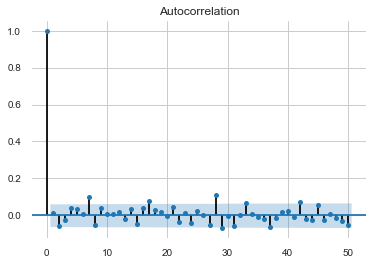

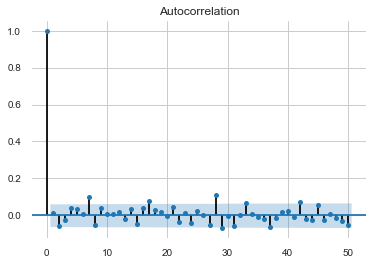

In [11]:
# Generate autocorrelation plot on training data.
plot_acf(aapl_diff, lags= 50)

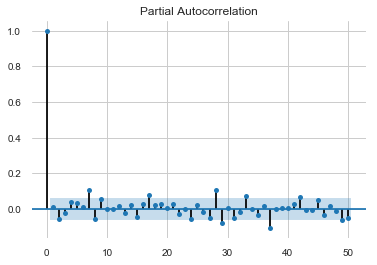

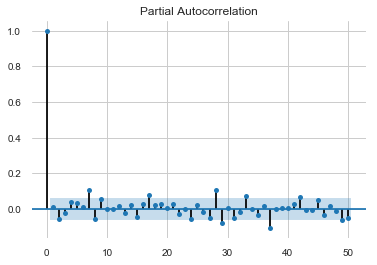

In [12]:
plot_pacf(aapl_diff, lags = 50)

From the acf and pacf plots above, it shows that p=1 and q=0.

## Test Model

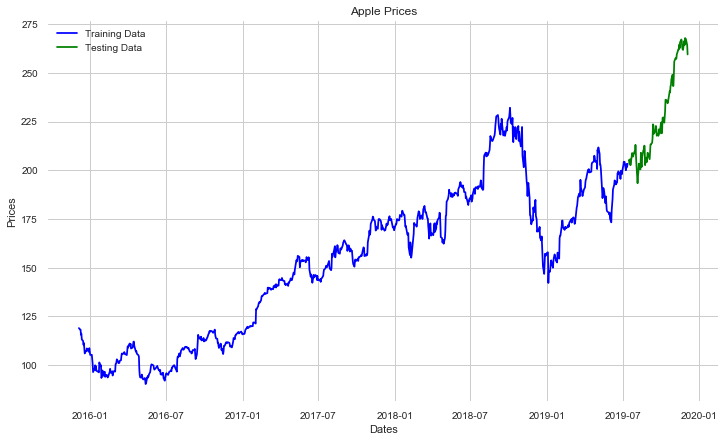

In [13]:
train_data, test_data = aapl_arima[0:int(len(aapl_arima)-100)], aapl_arima[int(len(aapl_arima)-100):]
plt.figure(figsize=(12,7))
plt.title('Apple Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

In [51]:
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = ARIMA(history, order = (1,1,0))
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 10)
        print(output)
        for i in output[0]:
            yhat = i
            predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = ARIMA(history, order=(1,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        for i in output[0]:
            yhat = i
            predictions.append(yhat)
#         yhat = output[0]
#         predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)

        
error = mean_squared_error(test_ar, predictions[:100])
print('Testing Mean Squared Error: %.3f' % error)

<class 'list'>
(array([264.2740281 , 264.41825353, 264.56276362, 264.7072764 ,
       264.8517892 , 264.99630201, 265.14081481, 265.28532761,
       265.42984042, 265.57435322]), array([2.5746926 , 3.65836619, 4.48769802, 5.18606161, 5.80095136,
       6.35663734, 6.86750609, 7.34291778, 7.78936731, 8.21157992]), array([[259.22772333, 269.32033288],
       [257.24798755, 271.5885195 ],
       [255.76703713, 273.35849011],
       [254.54278242, 274.87177038],
       [253.48213347, 276.22144494],
       [252.53752176, 277.45508226],
       [251.68075021, 278.60087941],
       [250.89347322, 279.677182  ],
       [250.16296102, 280.69671981],
       [249.47995232, 281.66875412]]))
Testing Mean Squared Error: 11.300


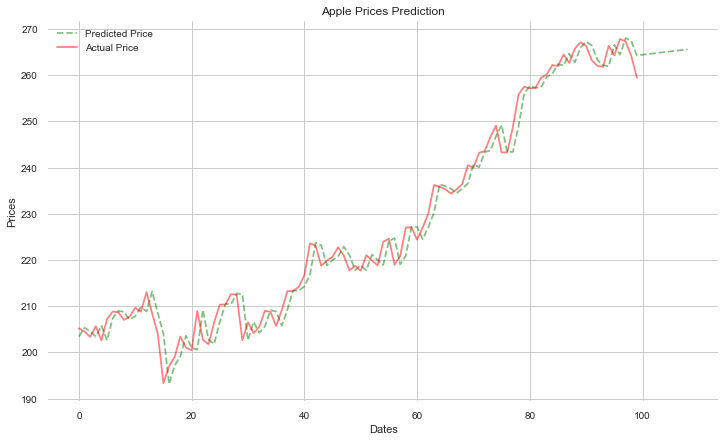

In [52]:
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions).reset_index(drop=True).index, predictions, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.reset_index(drop=True).index, test_data, color='red', alpha = 0.5, label='Actual Price')
plt.title('Apple Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

The model predicting the price that is just lagging behind the actual price. At the end when it is forecasting forward in time, it is unable to forecast the price and it just goes in a straight line. It is probably just forecasting the average forecasted movement in price. Due to this, I am unable to use this model to identify my reversal points. I will move on to other models.

# SARIMA

SARIMA is an extension of the ARIMA model with the inclusion of Seasonality.

In [16]:
aapl_sarima = aapl_arima.copy()
aapl_sarima.head()

,close_price
local_time,
2015-12-04 22:30:00,119.029999
2015-12-07 22:30:00,118.279999
2015-12-08 22:30:00,118.230003
2015-12-09 22:30:00,115.620003
2015-12-10 22:30:00,116.169998


## Determine Values for (p),(d),(q),(P),(D),(Q),(S)

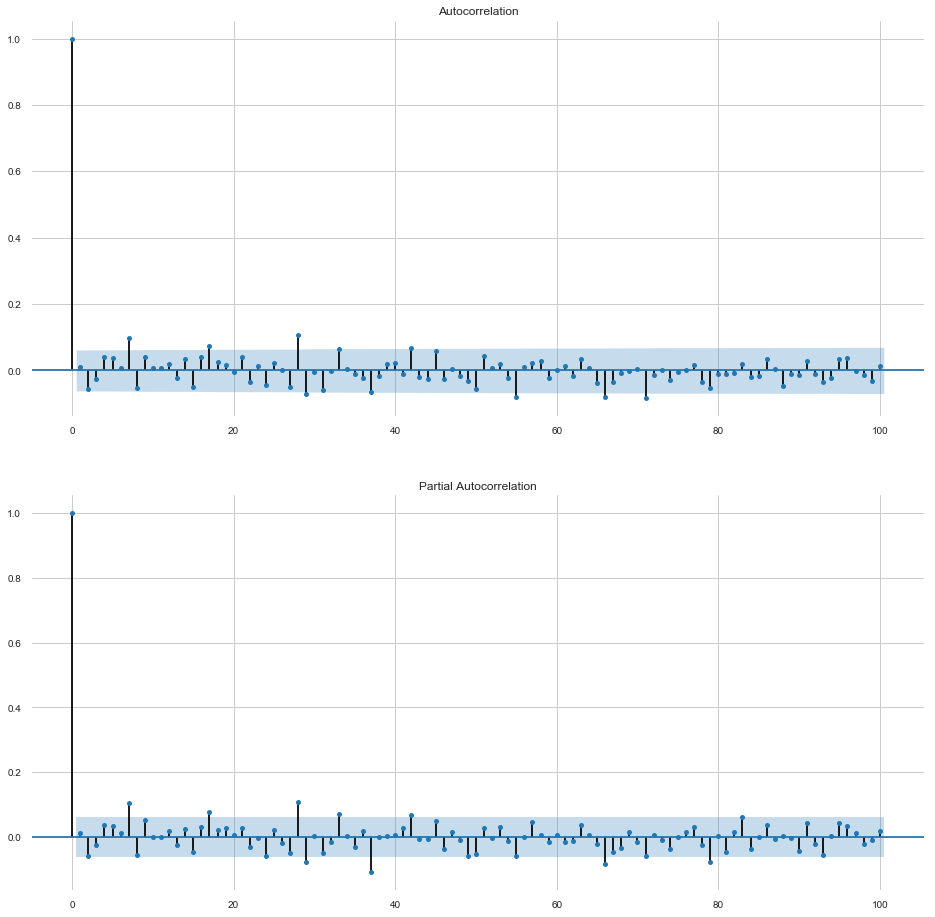

In [17]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(211)
fig = plot_acf(aapl_sarima.diff().dropna(), lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(aapl_sarima.diff().dropna(), lags=100, ax=ax2)
plt.show();

Using the plot to determine the p and q values. The performance for the model performed pretty badly. So to get opitmal performance, I will use a grid search to get the best parameters for my SARIMA model.

The metric I used to determine best parameters is using the lowest MSE.

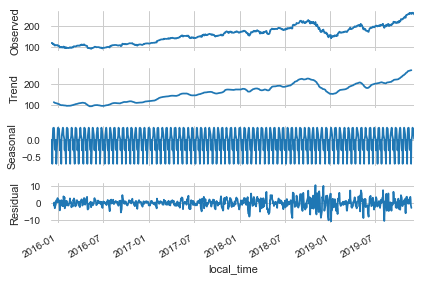

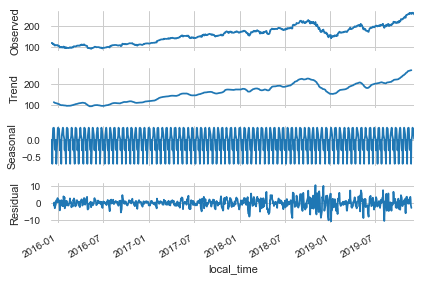

In [18]:
# A:
decomposition = seasonal_decompose(aapl_sarima['close_price'], freq =12)
decomposition.plot()

From the decomposition plot, we can see that there is the presence of seasonality in the price. Hence, using SARIMA would perform better.

### GridSearch

In [32]:
# Train test split
train_data, test_data = aapl_sarima[0:int(len(aapl_sarima)-100)], aapl_sarima[int(len(aapl_sarima)-100):]

In [33]:
# GRidSearch for Sarima
# Starting MSE and (P, D, Q).
mse = 99 * (10 ** 16)
final_P = 0
final_D = 0
final_Q = 0
final_S = 0

for P in range(4):
    for Q in range(4):
        for D in range(1,2):
            for S in range(4,17,4):
                for p in range(3,4):
                    for d in range(1):
                        for q in range(3,4):
                            try:
                                # Instantiate SARIMA model.
                                sarima = SARIMAX(endog = train_data.values,
                                                 order = (p, d, q),              # (p, d, q)
                                                 seasonal_order = (P, D, Q, S))  # (P, D, Q, S)) 

                                # Fit SARIMA model.
                                model = sarima.fit()

                                # Generate predictions based on training set.
                                preds = model.forecast(steps = len(test_data))

                                # Evaluate predictions.
                                print(f'The MSE for ({p},{d},{q})x({P},{D},{Q},{S}) is: {mean_squared_error(test_data.values, preds)}')

                                # Save for final report.
                                if mse > mean_squared_error(test_data.values, preds):
                                    mse = mean_squared_error(test_data.values, preds)
                                    final_P = P
                                    final_D = D
                                    final_Q = Q
                                    final_S = S
                                    final_p = p
                                    final_d = d
                                    final_q = q

                            except:
                                pass

print(f'Our model that minimizes MSE on the training data is the SARIMA({p},{d},{q})x({final_P},{final_D},{final_Q},{final_S}).')
print(f'This model has an MSE of {mse}.')

The MSE for (3,0,3)x(0,1,0,4) is: 1087.9756753783395


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,0,8) is: 988.3350599994492


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The MSE for (3,0,3)x(0,1,0,12) is: 822.8850215315297


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,0,16) is: 892.2910700085273


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The MSE for (3,0,3)x(0,1,1,4) is: 1083.3940730511538


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,1,8) is: 852.9705085265864


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,1,12) is: 1079.1781047172196


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,1,16) is: 875.7509872459518


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,2,4) is: 1087.8379935637577


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,2,8) is: 921.5651242688466
The MSE for (3,0,3)x(0,1,2,12) is: 1091.993187753713


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,2,16) is: 864.649597966388


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,3,4) is: 1078.5532271057946


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,3,8) is: 908.2448819410741
The MSE for (3,0,3)x(0,1,3,12) is: 1080.9759871116748


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(0,1,3,16) is: 866.6576624733783


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,0,4) is: 1083.879595049513


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,0,8) is: 916.6153343926351
The MSE for (3,0,3)x(1,1,0,12) is: 713.4022914130667


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,0,16) is: 617.2149293043672
The MSE for (3,0,3)x(1,1,1,4) is: 1122.2820076940861


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,1,8) is: 995.204960830634
The MSE for (3,0,3)x(1,1,1,12) is: 1068.5869132807986


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The MSE for (3,0,3)x(1,1,1,16) is: 983.4735538994084


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,2,4) is: 1123.2681118860623


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,2,8) is: 1115.4597294524042


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,2,12) is: 1080.3307602431173


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,2,16) is: 1005.9406267424366


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,3,4) is: 1065.1279152483653


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,3,8) is: 1100.6292871895714


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,3,12) is: 1099.502141323179


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(1,1,3,16) is: 976.4354394213991


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,0,4) is: 1088.9819444077168


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,0,8) is: 922.8866634243719


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,0,12) is: 613.100555093682


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,0,16) is: 973.8454192207157


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,1,4) is: 1119.4214712180446


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,1,8) is: 1003.0177168830097
The MSE for (3,0,3)x(2,1,1,12) is: 1087.4296498655356


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,1,16) is: 877.4836761973696


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,2,4) is: 1191.2447607775175


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,2,8) is: 1116.2091354809108


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,2,12) is: 1086.6639328290237


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,2,16) is: 961.1177210856456


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,3,4) is: 1163.9047955315973


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,3,8) is: 1060.4050689978471


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,3,12) is: 1085.0416055887722


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(2,1,3,16) is: 836.5569268903723


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,0,4) is: 1079.5031711295253


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,0,8) is: 648.2529122142437


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,0,12) is: 1055.6374438994708


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,0,16) is: 1024.9942208270656


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,1,4) is: 1064.133051053891


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The MSE for (3,0,3)x(3,1,1,8) is: 1039.5822550928062
The MSE for (3,0,3)x(3,1,1,12) is: 1111.1909448793974


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,1,16) is: 847.5150450398002


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,2,4) is: 1197.468242811235


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,2,8) is: 1090.0018187994008


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,2,12) is: 1118.666284211411


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,2,16) is: 854.1423050856116


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,3,4) is: 1102.6187819137897


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,3,8) is: 1077.9226647611295


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,3,12) is: 1011.4430113665028


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The MSE for (3,0,3)x(3,1,3,16) is: 799.0239459469058
Our model that minimizes MSE on the training data is the SARIMA(3,0,3)x(2,1,0,12).
This model has an MSE of 613.100555093682.


Every GridSearch seems to have a different result. So I will run a few gridsearches and check the forecasting results with the best parameters from each GridSearch and then use the model with lowest RMSE.


GS 1) Our model that minimizes MSE on the training data is the SARIMA(3,0,3)x(1,1,0,12).
This model has an MSE of 558.9790436616273.

GS 2) Our model that minimizes MSE on the training data is the SARIMA(3,0,3)x(3,1,0,8).
This model has an MSE of 697.3720827896345.

GS 3) Our model that minimizes MSE on the training data is the SARIMA(3,0,3)x(2,1,0,16).
This model has an MSE of 613.100555093682.

### Check Forecasting

#### GridSearch 1 Results

In [34]:
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]

# Instantiate SARIMA model.
sarima = SARIMAX(endog = history,
                 order = (3, 0, 3),              # (p, d, q)
                 seasonal_order = (1, 1, 0, 12))  # (P, D, Q, S)) 

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on training set.
preds = model.forecast(steps = len(test_data))

# Evaluate predictions.
print(f'The RMSE for (3,0,3)x(1, 1, 0, 12) is: {np.sqrt(mean_squared_error(test_ar, preds))}')

The RMSE for (3,0,3)x(1, 1, 0, 12) is: 26.709591749277386


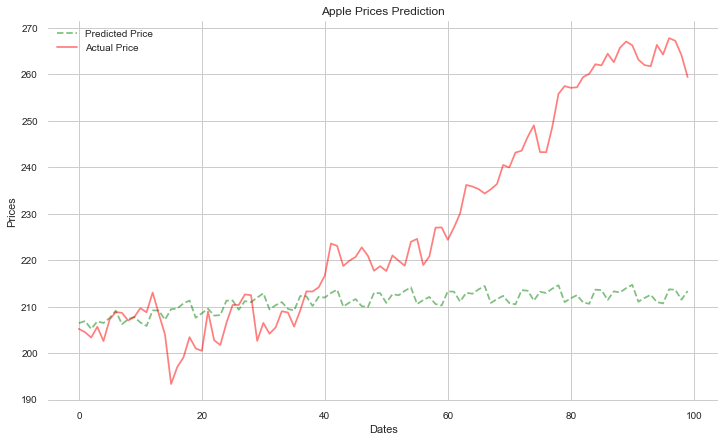

In [35]:
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(preds[:100]).reset_index(drop=True).index, preds[:100], color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data[:100].reset_index(drop=True).index, test_data[:100], color='red', alpha = 0.5, label='Actual Price')
plt.title('Apple Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

From the gridsearch parameters. The predicted price keeps repeating its pattern and is not usable for forecasting. Especially for the huge movements. 

#### GridSearch 2 Results

In [36]:
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]

# Instantiate SARIMA model.
sarima = SARIMAX(endog = history,
                 order = (3, 0, 3),              # (p, d, q)
                 seasonal_order = (3, 1, 0, 8))  # (P, D, Q, S)) 

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on training set.
preds = model.forecast(steps = len(test_data))

# Evaluate predictions.
print(f'The RMSE for (3,0,3)x(3, 1, 0, 8) is: {np.sqrt(mean_squared_error(test_ar, preds))}')

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The RMSE for (3,0,3)x(3, 1, 0, 8) is: 25.46081130314279


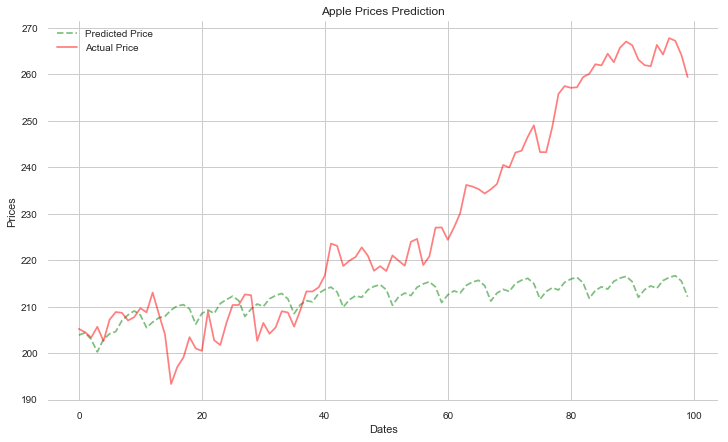

In [37]:
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(preds[:100]).reset_index(drop=True).index, preds[:100], color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data[:100].reset_index(drop=True).index, test_data[:100], color='red', alpha = 0.5, label='Actual Price')
plt.title('Apple Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

From the gridsearch parameters. The predicted price is pretty decent for forecasting till about 15 periods in the future. After that it is not able to forecast the prices anymore. Especially for the huge movements. However, since we are only looking to forecast 10 periods ahead, we are still able to use this parameters and model.

#### GridSearch 3 Results

In [38]:
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]

# Instantiate SARIMA model.
sarima = SARIMAX(endog = history,
                 order = (3, 0, 3),              # (p, d, q)
                 seasonal_order = (2, 1, 0, 16))  # (P, D, Q, S)) 

# Fit SARIMA model.
model = sarima.fit()

# Generate predictions based on training set.
preds = model.forecast(steps = len(test_data))

# Evaluate predictions.
print(f'The RMSE for (3,0,3)x(2, 1, 0, 16) is: {np.sqrt(mean_squared_error(test_ar, preds))}')

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


The RMSE for (3,0,3)x(2, 1, 0, 16) is: 31.206496426557013


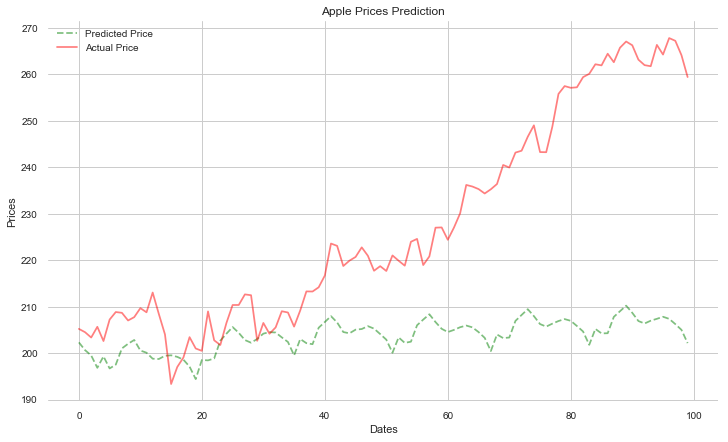

In [39]:
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(preds[:100]).reset_index(drop=True).index, preds[:100], color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data[:100].reset_index(drop=True).index, test_data[:100], color='red', alpha = 0.5, label='Actual Price')
plt.title('Apple Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

From the gridsearch parameters. The predicted price is able follow the actual price forecasting till about 10 periods in the future. However, the prices are being under predicted. After that it is not able to forecast the prices anymore. Especially for the huge movements. However, since we are only looking to forecast 10 periods ahead, we are still able to use this parameters and model.

## Test Model

Using the checking results, the gridsearch result with the lowest RMSE is gridsearch 2

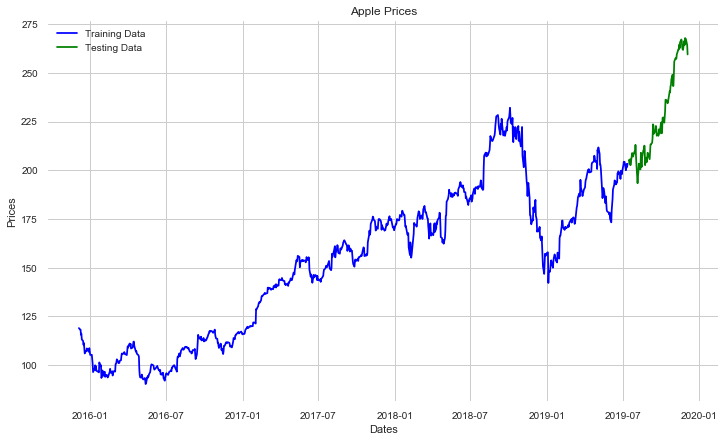

In [42]:
train_data, test_data = aapl_sarima[0:int(len(aapl_sarima)-100)], aapl_sarima[int(len(aapl_sarima)-100):]
plt.figure(figsize=(12,7))
plt.title('Apple Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(train_data, 'blue', label='Training Data')
plt.plot(test_data, 'green', label='Testing Data')
plt.legend()

In [43]:
train_ar = train_data.values
test_ar = test_data.values
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    if (t == len(test_ar) - 1):
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3, 1, 0, 8))
        model_fit = model.fit(disp = 0)
        output = model_fit.forecast(steps = 10)
        print(output)
        for i in output:
            yhat = i
            predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)
    else:
        model = SARIMAX(history, order = (3,0,3), seasonal_order = (3, 1, 0, 8))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
#         for i in output[0]:
#             yhat = i
#             predictions.append(yhat)
        yhat = output[0]
        predictions.append(yhat)
        obs = test_ar[t]
        history.append(obs)

        
error = mean_squared_error(test_ar, predictions[:100])
print('Testing Mean Squared Error: %.3f' % error)

<class 'list'>


/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/sta

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/edwinotw/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood opti

[262.34436645 262.71766192 264.29021304 267.12177213 266.99968532
 268.45855534 269.12087736 268.99756194 266.09073706 265.88255201]
Testing Mean Squared Error: 13.722


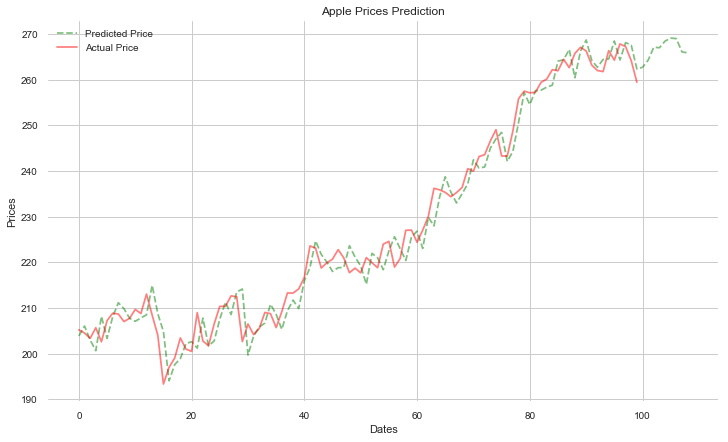

In [44]:
plt.figure(figsize=(12,7))
plt.plot(pd.DataFrame(predictions).reset_index(drop=True).index, predictions, color='green', alpha = 0.5, linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data[:100].reset_index(drop=True).index, test_data[:100], color='red', alpha = 0.5, label='Actual Price')
plt.title('Apple Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

The Graph shows that the predicted price does well in following the actual price of the stock. At the end, there is movement in forecasted prices that looks similar to how a stock price would move. Hence this is a promising model that I can use to determine my reversal points.